In [1]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import random
import imgkit
import os
import matplotlib.pyplot as plt
import scipy.stats
import community as community_louvain
from statsmodels.distributions.empirical_distribution import ECDF

dataset = json.load(open('datasets/dataset.json'))
 
totaltweets = 0
totalusers = len(dataset)
totalrt = 0
userlist = list()
realusers = list()

usernames = list()
for user in dataset:
    userlist.append(user['handle'])
    realusers.append(user['handle'])
    totaltweets = totaltweets + len(user['tweets'])
    for tweet in user['tweets']:
        realusers.append(list(tweet['retweeted_from'].keys())[0])

print("Are there user duplicates in the list? "+str(len(userlist) != len(set(userlist))))
print("We have a total of "+str(totalusers)+" users and "+str(totaltweets)+" retweets.")
print("We calculate around "+str(totaltweets/totalusers)+" tweets per user.")

realusers = list(dict.fromkeys(realusers))
print("Total unique users (OC+RT) detected: "+str(len(realusers)))

Are there user duplicates in the list? False
We have a total of 35682 users and 127461 retweets.
We calculate around 3.5721372120396837 tweets per user.
Total unique users (OC+RT) detected: 40347


In [2]:
print("Generating edge list...", end=" ")
twitter_d = nx.DiGraph()
for user in dataset:
    username = user['handle']
    for tweet in user['tweets']:
        rt_oc_user = list(tweet['retweeted_from'].keys())[0]
        link = (username,rt_oc_user)
        if username == rt_oc_user:
            continue #User is retweeting himself; avoid self-loops
        twitter_d.add_edge(username, rt_oc_user)
print("Done.")
print('Preformatted nodes: {}'.format(twitter_d.order()))

print('Removing nodes outside of Giant Component...', end='')
weak_nodes = max(nx.weakly_connected_components(twitter_d), key=len)
nodelist = list()
for n in twitter_d.nodes():
    if n not in weak_nodes:
      nodelist.append(n)
twitter_d.remove_nodes_from(nodelist)
print(' '+str(len(nodelist))+ ' nodes removed.')

print('Number of nodes: {}'.format(twitter_d.order()))
print('Number of links: {}'.format(twitter_d.size()))
density = nx.density(twitter_d)
print('Density: {}'.format(density))

Generating edge list... Done.
Preformatted nodes: 40261
Removing nodes outside of Giant Component... 3315 nodes removed.
Number of nodes: 36946
Number of links: 84807
Density: 6.213103721248901e-05


In [3]:
degree = list(dict(twitter_d.degree()).values())
in_degree = list(dict(twitter_d.in_degree()).values())
out_degree = list(dict(twitter_d.out_degree()).values())

dt = ({'Degree Type':'Overall','Max':np.max(degree),'Min':np.min(degree),'Mean':np.mean(degree),'Standard Deviation':np.std(degree),'Median':np.median(degree)},
{'Degree Type':'In-Degree','Max':np.max(in_degree),'Min':np.min(in_degree),'Mean':np.mean(in_degree),'Standard Deviation':np.std(in_degree),'Median':np.median(in_degree)},
{'Degree Type':'Out-Degree','Max':np.max(out_degree),'Min':np.min(out_degree),'Mean':np.mean(out_degree),'Standard Deviation':np.std(out_degree),'Median':np.median(out_degree)})
df = pd.DataFrame(dt)


## Enter your css for the table.
css = """
<style type=\"text/css\">
table {
color: #333;
font-family: Helvetica, Arial, sans-serif;
width: 1000px;
border-collapse:
collapse; 
border-spacing: 0;
}

td, th {
border: 1px solid transparent; /* No more visible border */
height: 30px;
}

th {
background: #DFDFDF; /* Darken header a bit */
font-weight: bold;
text-align: left;
}

td {
background: #FAFAFA;
text-align: left;
}

table tr:nth-child(odd) td{
background-color: white;
}
</style>
"""
def DataFrame_to_image(data, css, outputfile="degree.png", format="png"):
    '''
    For rendering a Pandas DataFrame as an image.
    data: a pandas DataFrame
    css: a string containing rules for styling the output table. This must 
         contain both the opening an closing <style> tags.
    *outputimage: filename for saving of generated image
    *format: output format, as supported by IMGKit. Default is "png"
    '''
    fn = str(random.random()*100000000).split(".")[0] + ".html"
    
    try:
        os.remove(fn)
    except:
        None
    text_file = open(fn, "a")
    
    # write the CSS
    text_file.write(css)
    # write the HTML-ized Pandas DataFrame
    text_file.write(data.to_html())
    text_file.close()
    
    # See IMGKit options for full configuration,
    # e.g. cropping of final image
    imgkitoptions = {"format": format}
    
    imgkit.from_file(fn, outputfile, options=imgkitoptions)
    os.remove(fn)
    
    
DataFrame_to_image(df, css)

df #Prints previously generated DataFrame


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,Degree Type,Max,Min,Mean,Standard Deviation,Median
0,Overall,6032,1,4.590862,39.908668,1.0
1,In-Degree,6032,0,2.295431,39.663015,0.0
2,Out-Degree,198,0,2.295431,4.215178,1.0


Text(0, 0.5, 'ECDF')

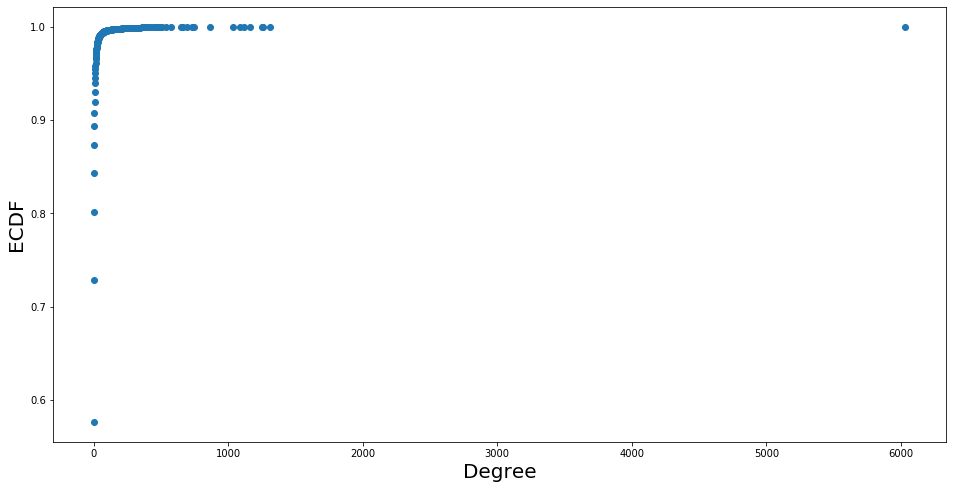

In [4]:
# ECDF linear scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='None')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECDF', size = 20)

Text(0, 0.5, 'ECDF')

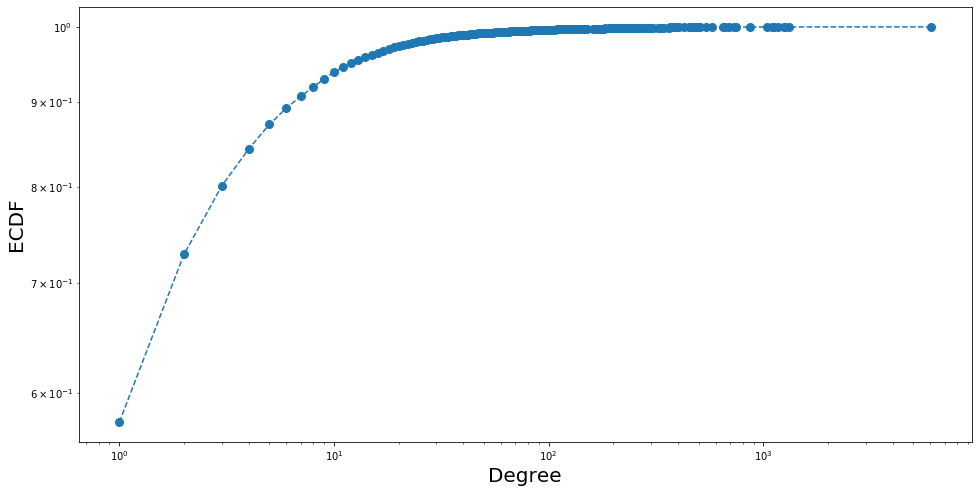

In [5]:
# ECDF loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECDF', size=20)

Text(0, 0.5, 'ECCDF')

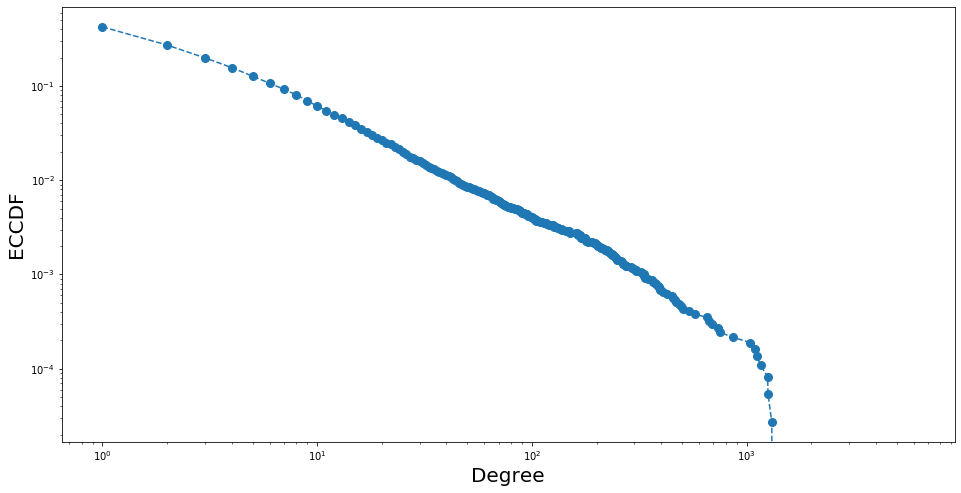

In [6]:
#ECCDF in loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)

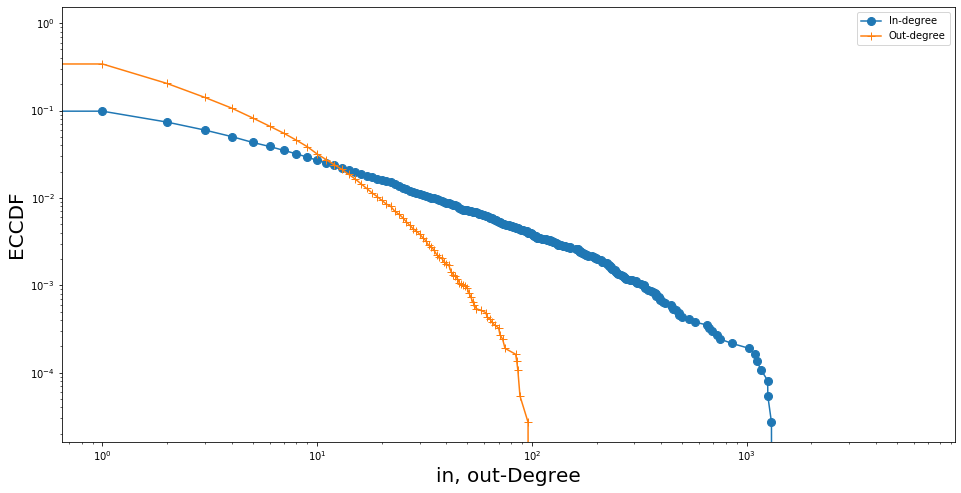

In [7]:
# ECCDF in-degree
cdf = ECDF(in_degree)
x = np.unique(in_degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8,label='In-degree')
cdf = ECDF(out_degree)
x = np.unique(out_degree)
y = cdf(x)
axes.loglog(x,1-y,marker='+',ms=8,label='Out-degree')
axes.set_xlabel('in, out-Degree',size=20)
axes.set_ylabel('ECCDF', size=20)
axes.legend()
fig_cdf.savefig('eccdfconfronto.png')

Number of nodes: 36946
Number of links: 42628


Text(0, 0.5, 'ECCDF')

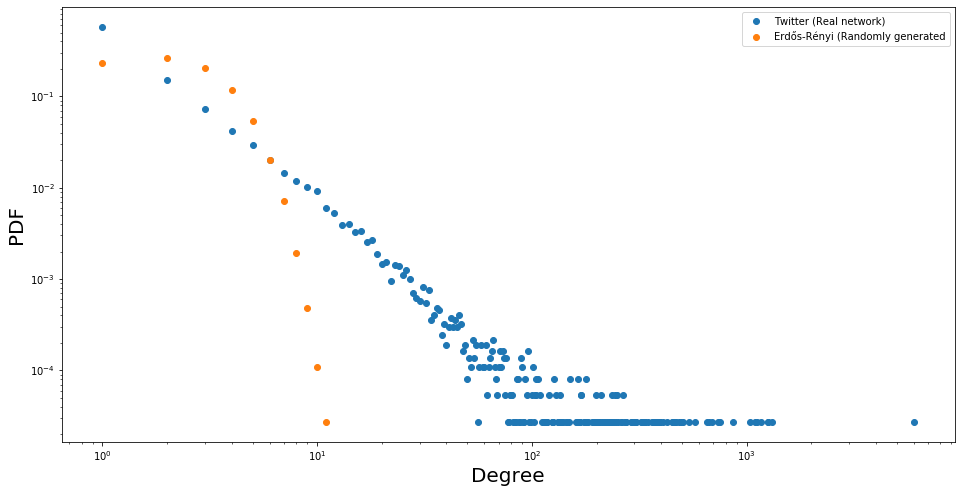

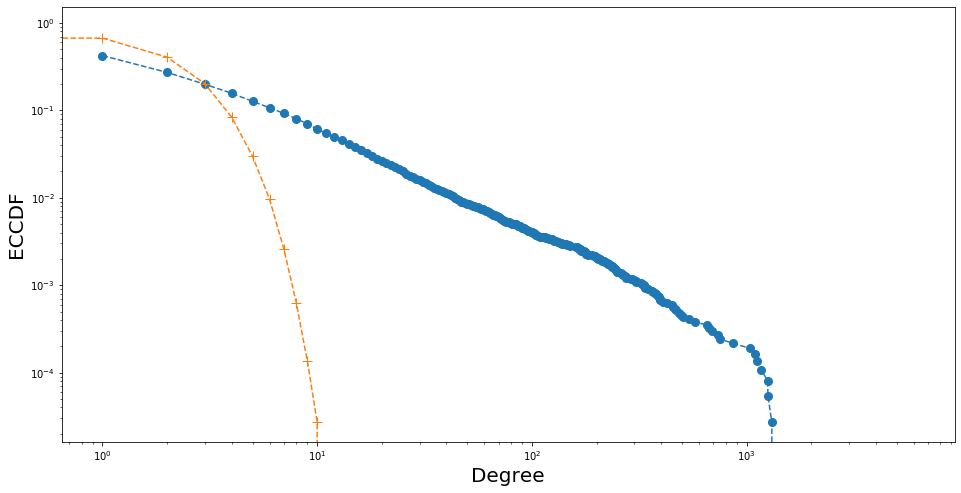

In [8]:
p = density
random_graph = nx.fast_gnp_random_graph(twitter_d.order(),p)
print('Number of nodes: {}'.format(random_graph.order()))
print('Number of links: {}'.format(random_graph.size()))
random_degree = list(dict(random_graph.degree()).values())

#PDF loglog scale, random vs real
count, bins = np.histogram(degree,np.arange(np.min(degree),np.max(degree)+2))
x = bins[:-1]
y = count/(twitter_d.order()) #PDF
count_random, bins_random = np.histogram(random_degree,np.arange(np.min(random_degree),np.max(random_degree)+2))
x_random = bins_random[:-1]
y_random = count_random/(random_graph.order()) #PDF
fig = plt.figure(figsize=(16,8))
axes = fig.gca()
axes.loglog(x,y,marker='o',linestyle='None', ms = 6, label = 'Twitter (Real network)')
axes.loglog(x_random,y_random,marker='o',linestyle='None', ms = 6, label ='Erdős-Rényi (Randomly generated')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('PDF',size=20)
axes.legend()
plt.savefig('pdfconfronto.png')

#ECCDF loglog scale, random vs real
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
cdf_random = ECDF(random_degree)
x_random = np.unique(random_degree)
y_random = cdf_random(x_random)
fig_cdf_fb = plt.figure(figsize=(16,8))
axes = fig_cdf_fb.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.loglog(x_random,1-y_random,marker='+',ms=10, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)

In [9]:
print('Graph is weakly connected') if nx.is_weakly_connected(twitter_d) else print('Graph is not weakly connected.')
print('Number of weakly connected components: {}'.format(nx.number_weakly_connected_components(twitter_d)))
print('Graph is strongly connected') if nx.is_strongly_connected(twitter_d) else print('Graph is not strongly connected.')
print('Number of strongly connected components: {}'.format(nx.number_strongly_connected_components(twitter_d)))
print('Overall reciprocity: {}'.format(nx.overall_reciprocity(twitter_d)))

Graph is weakly connected
Number of weakly connected components: 1
Graph is not strongly connected.
Number of strongly connected components: 36527
Overall reciprocity: 0.00393835414529461


In [10]:
percentile_99 = np.percentile(degree,99.9)
print('Degree of nodes (hubs) above 99th percentile: {}'.format(percentile_99))

Degree of nodes (hubs) above 99th percentile: 332.05500000000757


In [11]:
hub_nodi = [k for k,v in dict(twitter_d.degree()).items() if v>= percentile_99]
print(len(hub_nodi))
print(list(hub_nodi))

37
['MediasetTgcom24', 'you_trend', 'Adnkronos', 'Agenzia_Ansa', 'RadioSavana', 'benq_antonio', 'TarroGiulio', 'VittorioSgarbi', 'SkyTG24', 'repubblica', 'MedicalFactsIT', 'Corriere', 'Pontifex_it', 'CesareSacchetti', 'IlariaBifarini', 'ItalyQanons', 'NonVaccinato', 'Stefbazzi', 'ilpost', 'francescatotolo', 'LaStampa', 'matteosalvinimi', 'GiorgiaMeloni', 'DSantanche', 'giorgiamennuni', 'fattoquotidiano', 'molumbe', 'VNotKind', 'GiancarloDeRisi', 'matteorenzi', 'Cartabellotta', 'marco_gervasoni', 'jeperego', 'Pgreco_', 'GrimoldiPaolo', 'christianrocca', 'davcarretta']


In [12]:
print('Transitivity: {}'.format(nx.transitivity(twitter_d)))
print('Average clustering: {}'.format(nx.average_clustering(twitter_d)))
#TODO: This is the same as the average clustering! Should we keep this?
print('Mean local clustering: {}'.format(np.mean(list(nx.clustering(twitter_d).values()))))
print('Standard deviation local clustering: {}'.format(np.std(list(nx.clustering(twitter_d).values()))))

Transitivity: 0.030538634596011003
Average clustering: 0.020231763272201532
Mean local clustering: 0.020231763272201535
Standard deviation local clustering: 0.08245886535992575


In [13]:
degree=dict(nx.degree(twitter_d))
degree_centrality = nx.degree_centrality(twitter_d)
closeness_centrality = nx.closeness_centrality(twitter_d)
eigenvector_centrality = nx.eigenvector_centrality(twitter_d)

# lambda function or anonimous function. no name, no return, no def, just use the keyword lambda
# Sintax: lambda argument: manipulate(argument)
hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_closeness = sorted(closeness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
print('degree:      ',hub_degree)
print('closeness:   ',hub_closeness)
print('eigenvector: ',hub_eigenvector)
#print('Beware: betweenness centrality is valued for approximately 10% of the network, due to the sheer time needed for the calculation.')
#betweenness_centrality=nx.betweenness_centrality(twitter_d, k=3600)
#hub_betweenness = sorted(betweenness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
#print('betweenness: ',hub_betweenness)

#--- BETWEENNESS CENTRALITY MULTIPROCESSING ---#
from multiprocessing import Pool
import time
import itertools

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_source,
        zip([G] * num_chunks, [True] * num_chunks, [None] * num_chunks, node_chunks),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


print("")
print("Computing betweenness centrality for:")
print(nx.info(twitter_d))
print("\tParallel version")
start = time.time()
betweenness_centrality = betweenness_centrality_parallel(twitter_d)
print(f"\t\tTime: {(time.time() - start):.4F} seconds")
#--- BETWEENNESS CENTRALITY MULTIPROCESSING ---#

hub_betweenness = sorted(betweenness_centrality.items(),key = lambda x:x[1], reverse=True)[0]
print('betweenness: ',hub_betweenness)

degree:       ('RadioSavana', 0.1632697252672892)
closeness:    ('RadioSavana', 0.08487170409446092)
eigenvector:  ('RadioSavana', 0.6272093284012229)

Computing betweenness centrality for:
Name: 
Type: DiGraph
Number of nodes: 36946
Number of edges: 84807
Average in degree:   2.2954
Average out degree:   2.2954
	Parallel version
		Time: 284.3114 seconds
betweenness:  ('Paolorm2012Roma', 0.0032805880627740035)


In [14]:
in_degree_centrality = dict(twitter_d.in_degree())
out_degree_centrality = dict(twitter_d.out_degree())
pr_centrality = dict(nx.pagerank_scipy(twitter_d))

In [15]:
hub_in_degree = sorted(in_degree_centrality.items(),key= lambda x:x[1], reverse=True)[0]
hub_out_degree = sorted(out_degree_centrality.items(),key= lambda x:x[1], reverse=True)[0]
hub_pagerank = sorted(pr_centrality.items(),key= lambda x:x[1], reverse=True)[0]

print('in_degree:  ',hub_in_degree)
print('out_degree: ',hub_out_degree)
print('pagerank:   ',hub_pagerank)

in_degree:   ('RadioSavana', 6032)
out_degree:  ('generacomplotti', 198)
pagerank:    ('RadioSavana', 0.04313068309436492)


In [16]:
print(scipy.stats.pearsonr(list(in_degree_centrality.values()),list(out_degree_centrality.values())))
print(scipy.stats.pearsonr(list(in_degree_centrality.values()),list(pr_centrality.values())))
print(scipy.stats.pearsonr(list(out_degree_centrality.values()),list(pr_centrality.values())))

(0.005321517802032209, 0.3063836029835979)
(0.9547398743226766, 0.0)
(-0.003435729810007406, 0.5090144991084367)


Text(0, 0.5, 'Out_degree')

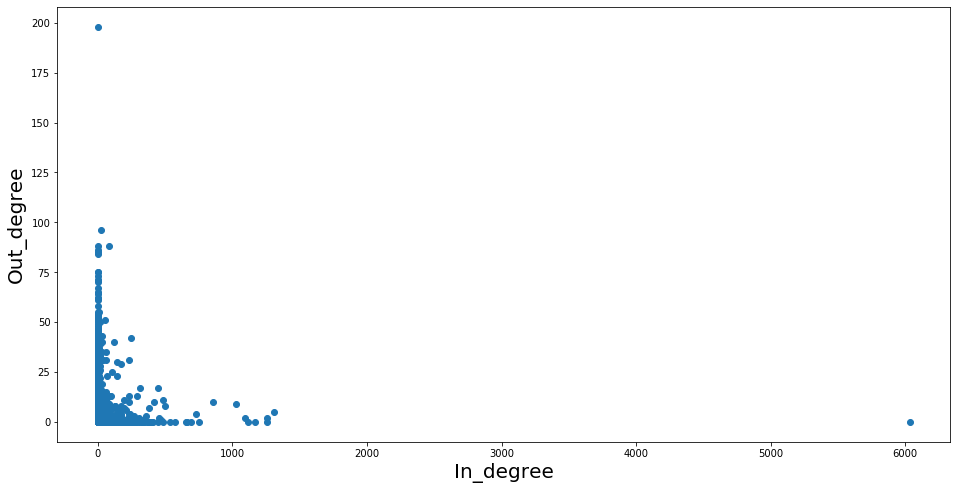

In [17]:
fig = plt.figure(figsize=(16,8)) 
axes = fig.gca()
plt.scatter(list(in_degree_centrality.values()),list(out_degree_centrality.values()))
axes.set_xlabel('In_degree',size = 20)
axes.set_ylabel('Out_degree',size = 20)

In [41]:
print('Degree assortativity coefficient: {}'.format(nx.degree_assortativity_coefficient(twitter_d)))
print('ASP: {}'.format(nx.average_shortest_path_length(twitter_d.to_undirected())))

Degree assortativity coefficient: -0.1103388532309484
ASP: 4.589826807691601


In [43]:
partition = community_louvain.best_partition(twitter_d.to_undirected(),randomize=True,resolution=1.0)
communities = {}
for i in set(partition.values()):
    communities[i] = list()
for i in partition:
    communities[partition[i]].append(i)
temp = {}
for k in sorted(communities, key=lambda k: len(communities[k]), reverse=True):
        temp[k] = communities[k]
communities = temp
for i in communities:
    print("Community {}, size: {}".format(i,len(communities[i])))
print("Communities detected: {}".format(len(communities)))
print("Modularity: {}".format(community_louvain.modularity(partition,twitter_d.to_undirected())))
for i in twitter_d.nodes:
    nx.set_node_attributes(twitter_d, {i:partition[i]}, 'community')

Community 8, size: 9702
Community 1, size: 5138
Community 7, size: 3126
Community 5, size: 2959
Community 12, size: 2484
Community 4, size: 1974
Community 0, size: 1804
Community 9, size: 1724
Community 30, size: 1123
Community 10, size: 687
Community 16, size: 559
Community 22, size: 505
Community 15, size: 450
Community 23, size: 406
Community 24, size: 376
Community 29, size: 335
Community 20, size: 322
Community 11, size: 305
Community 13, size: 293
Community 14, size: 280
Community 2, size: 273
Community 21, size: 239
Community 6, size: 233
Community 44, size: 225
Community 3, size: 198
Community 17, size: 183
Community 19, size: 163
Community 26, size: 153
Community 32, size: 149
Community 18, size: 119
Community 64, size: 102
Community 41, size: 30
Community 52, size: 24
Community 43, size: 19
Community 35, size: 18
Community 42, size: 16
Community 25, size: 15
Community 37, size: 15
Community 45, size: 14
Community 54, size: 14
Community 51, size: 13
Community 55, size: 13
Comm

In [79]:
#Print table for 20 top degree
dt = list()
for i in sorted(twitter_d.degree, key=lambda x: x[1], reverse=True)[:37]:
    user = {}
    user['User Handle'] = i[0]
    user['Degree'] = i[1]
    user['In-Degree'] = twitter_d.in_degree(i[0])
    user['Out-Degree'] = twitter_d.out_degree(i[0])
    user['Degree Centrality'] = degree_centrality.get(i[0])
    user['Closeness Centrality'] = closeness_centrality.get(i[0])
    user['Eigenvector Centrality'] = eigenvector_centrality.get(i[0])
    user['Betweenness Centrality'] = betweenness_centrality.get(i[0])
    user['PageRank'] = pr_centrality.get(i[0])
    user['Community'] = partition[i[0]]
    handle = i[0]
    links = list()
    for x in dataset:
        for y in x.get("tweets",""):
            if list(y.get("retweeted_from","").keys())[0] == handle:
                linkGenerator = "https://twitter.com/"+handle+"/status/"+str(y.get("retweeted_from","")[handle])
                links.append(linkGenerator)
    links = list(set(links))
    user['Tweets'] = len(links)
    
    dt.append(user)
df = pd.DataFrame(dt)

## Enter your css for the table.
css = """
<style type=\"text/css\">
table {
color: #333;
font-family: Helvetica, Arial, sans-serif;
width: 1500px;
border-collapse:
collapse; 
border-spacing: 0;
}

td, th {
border: 1px solid transparent; /* No more visible border */
height: 30px;
}

th {
background: #DFDFDF; /* Darken header a bit */
font-weight: bold;
text-align: left;
}

td {
background: #FAFAFA;
text-align: left;
}

table tr:nth-child(odd) td{
background-color: white;
}
</style>
"""
def DataFrame_to_image(data, css, outputfile="out.png", format="png"):
    '''
    For rendering a Pandas DataFrame as an image.
    data: a pandas DataFrame
    css: a string containing rules for styling the output table. This must 
         contain both the opening an closing <style> tags.
    *outputimage: filename for saving of generated image
    *format: output format, as supported by IMGKit. Default is "png"
    '''
    fn = str(random.random()*100000000).split(".")[0] + ".html"
    
    try:
        os.remove(fn)
    except:
        None
    text_file = open(fn, "a")
    
    # write the CSS
    text_file.write(css)
    # write the HTML-ized Pandas DataFrame
    text_file.write(data.to_html())
    text_file.close()
    
    # See IMGKit options for full configuration,
    # e.g. cropping of final image
    imgkitoptions = {"format": format}
    
    imgkit.from_file(fn, outputfile, options=imgkitoptions)
    os.remove(fn)
    
    
DataFrame_to_image(df, css)

df #Prints previously generated DataFrame

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,User Handle,Degree,In-Degree,Out-Degree,Degree Centrality,Closeness Centrality,Eigenvector Centrality,Betweenness Centrality,PageRank,Community,Tweets
0,RadioSavana,6032,6032,0,0.163270,0.084872,0.627209,0.000000e+00,0.043131,8,102
1,Agenzia_Ansa,1311,1306,5,0.035485,0.060109,0.120247,3.794716e-05,0.005995,1,242
2,Cartabellotta,1258,1256,2,0.034051,0.071182,0.036095,1.303863e-05,0.010955,7,46
3,giorgiamennuni,1254,1254,0,0.033942,0.059350,0.097716,0.000000e+00,0.007208,16,1
4,GrimoldiPaolo,1166,1166,0,0.031560,0.031792,0.010627,0.000000e+00,0.011814,30,6
5,CesareSacchetti,1117,1117,0,0.030234,0.035835,0.173170,0.000000e+00,0.003956,8,18
6,francescatotolo,1092,1090,2,0.029557,0.041449,0.139711,1.145190e-05,0.003144,8,38
7,Corriere,1039,1030,9,0.028123,0.063392,0.119571,9.731336e-05,0.007912,1,277
8,repubblica,862,852,10,0.023332,0.051073,0.021271,1.006331e-04,0.007471,1,360
9,Pontifex_it,749,749,0,0.020273,0.038130,0.009477,0.000000e+00,0.006013,9,2


In [80]:
best_communities = list()
for i in dt:
    if i.get("Community","") not in best_communities:
        best_communities.append(i.get("Community",""))
print("Hubs communities: {}".format(best_communities))
print("")

dataset = json.load(open('datasets/dataset.json'))

for i in best_communities:
    temp = list()
    avgtweets = list()
    for j in dt:
        if j.get("Community","") == i:
            temp.append(j.get("User Handle",""))
            handle = j.get("User Handle","")
            links = list()
            for x in dataset:
                for y in x.get("tweets",""):
                    if list(y.get("retweeted_from","").keys())[0] == handle:
                        linkGenerator = "https://twitter.com/"+handle+"/status/"+str(y.get("retweeted_from","")[handle])
                        links.append(linkGenerator)
            links = list(set(links))
            avgtweets.append(len(links))
    
    print("Community: {} [{} nodes]".format(i,len(communities[i])))
    print("Main hubs: {}".format(temp))
    print("Average tweets per hub: {}".format(np.mean(avgtweets)))
    print('Average clustering: {}'.format(nx.average_clustering(twitter_d,communities[i])))
    print('Standard deviation local clustering: {}'.format(np.std(list(nx.clustering(twitter_d,communities[i]).values()))))
    print('Degree assortativity coefficient: {}'.format(nx.degree_assortativity_coefficient(twitter_d,nodes=communities[i])))
    print('Reciprocity: {}'.format(np.mean(list(nx.reciprocity(twitter_d,nodes=communities[i]).values()))))
    print("Assortativity correlation with communities:")
   
    #for y in best_communities:
    #    if y == i:
    #       continue
    #    else:
    #        print("Community {}: {}".format(y,nx.numeric_assortativity_coefficient(twitter_d,'community',nodes=communities[i]+communities[y])))
    
    #TODO: Should we compare between all communities or just hub-prevalent ones?
    compare = dict()
    for y in best_communities:
        if (y == i) or (y == 30) or (y == 16): #Removing giorgiamennuni and grimoldipaolo
            continue
        else:
            compare[y] = nx.numeric_assortativity_coefficient(twitter_d,'community',nodes=communities[i]+communities[y])
    
    for comm, val in compare.items():
        if val == min(compare.values()):
            best = comm
        if val == max(compare.values()):
            worse = comm
    print("Best community is {} with value: {}".format(best, compare[best]))
    print("Worse community is {} with value: {}".format(worse, compare[worse]))
    

    
    print("")

Hubs communities: [8, 1, 7, 16, 30, 9, 4, 0, 5]

Community: 8 [9702 nodes]
Main hubs: ['RadioSavana', 'CesareSacchetti', 'francescatotolo', 'GiorgiaMeloni', 'TarroGiulio', 'Stefbazzi', 'NonVaccinato', 'molumbe', 'ItalyQanons', 'Pgreco_', 'benq_antonio', 'marco_gervasoni', 'matteosalvinimi', 'DSantanche', 'VittorioSgarbi', 'GiancarloDeRisi', 'VNotKind', 'IlariaBifarini']
Average tweets per hub: 19.0
Average clustering: 0.03887278015161909
Standard deviation local clustering: 0.10101988143114687
Degree assortativity coefficient: -0.27354154166750344
Reciprocity: 0.0013156397493637156
Assortativity correlation with communities:
Best community is 9 with value: 0.06716978218405283
Worse community is 0 with value: 0.5897362402630659

Community: 1 [5138 nodes]
Main hubs: ['Agenzia_Ansa', 'Corriere', 'repubblica', 'SkyTG24', 'MediasetTgcom24', 'Adnkronos', 'LaStampa']
Average tweets per hub: 254.71428571428572
Average clustering: 0.009362024822051654
Standard deviation local clustering: 0.0590